In [1]:
# Quick hack to fix local imports for the generated files
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from enum import IntEnum
from typing import Tuple
from collections import defaultdict, namedtuple
import random
import math
from copy import deepcopy
import pickle
from pathlib import Path
from operator import itemgetter

import flatbuffers
import pyrosm
import pandas as pd
import numpy as np
import geopandas
import rasterio
import rioxarray as rxr
import osmnx
import networkx as nx
from shapely.geometry import mapping, box, LineString
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.crs import CRS
from scipy.spatial import cKDTree
from scipy import stats

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [5]:
# This should be picked appropriately for the boundary area to avoid distortion, this example is in the UK so using 27700
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700 

# used as a folder name for pickles
DATASET_NAME = "wales"

In [6]:
Path(f"pickles/{DATASET_NAME}").mkdir(parents=True, exist_ok=True)

### Step 1: Acquire Boundary and Data from OpenStreetMap

##### Get OpenStreetMap data

In [7]:
%%time
fp = pyrosm.get_data("Wales",
                     directory='./data/osm_pbf_data',
#                      update=True
                    )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 916 µs


In [6]:
# Read all boundaries using the default settings
osm = pyrosm.OSM(fp)
boundaries = osm.get_boundaries()
boundaries.head(3) # left as an example to see possible Boundary choices

,name,admin_level,boundary,id,timestamp,version,tags,osm_type,geometry,website,postal_code,border_type,changeset
0,None,6,administrative,3494930,1363387587,9,"{""source"":""PGS"",""natural"":""coastline""}",way,"MULTILINESTRING ((-5.82513 57.41563, -5.82520 ...",NaN,NaN,NaN,NaN
1,None,6,administrative,3494991,1363387819,4,"{""source"":""PGS"",""natural"":""coastline""}",way,"MULTILINESTRING ((-5.82510 57.37198, -5.82519 ...",NaN,NaN,NaN,NaN
2,None,6,administrative,3494997,1363387819,6,"{""source"":""PGS"",""natural"":""coastline""}",way,"MULTILINESTRING ((-5.81313 57.37063, -5.81297 ...",NaN,NaN,NaN,NaN


##### Select Subset

In [7]:
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
boundary = osm.get_boundaries(name='Cymru / Wales')

# bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
# bbox = box(-0.161,51.449,-0.002,51.529)  # a random box containing City of London and some of South London like Brixton
# bbox = box(-0.417548,51.370878,0.144128,51.602621) # bigger box of London
# bbox = box(-0.599,51.179,0.328,51.562) # SE ~quadrant of the London commuter ring
# bbox = box(-2.387604,53.398281,-2.112259,53.55031)  # Greater Manchester
# bbox = box(-1.586208,50.571982,-1.060925,50.769553) # Isle of Wight
# boundary = geopandas.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# # Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]
# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)
# osm = pyrosm.OSM("./data/osm_pbf_data/se-england.pbf", bounding_box=bbox_geom)

##### Crudely get all places that might be considered workplaces

In [8]:
%%time
# pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois_filter = {"shop": True,"amenity": True}
pois = osm.get_pois(custom_filter=pois_filter)

office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)

office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

CPU times: user 6min 54s, sys: 2min 7s, total: 9min 2s
Wall time: 9min 3s


##### Combine the locations of all of the crude workplaces

In [9]:
%%time
trimmed_work = pois[['geometry']].copy()
trimmed_work = trimmed_work.append(offices[['geometry']]).append(office_buildings[['geometry']])
trimmed_work = trimmed_work.reset_index()
orig_crs = trimmed_work.crs
trimmed_work = trimmed_work.to_crs(OUT_CRS) # convert CRS to the final CRS for more correct centroids
trimmed_work['geometry'] = trimmed_work.geometry.convex_hull.centroid  # we use the convex hull because otherwise we get wildly incorrect points for non-convex polygons results
trimmed_work = trimmed_work.to_crs(orig_crs) # convert back for now
# trimmed_work.plot(markersize=0.1)
del pois, offices, office_buildings

CPU times: user 1.53 s, sys: 46.9 ms, total: 1.58 s
Wall time: 1.6 s


##### Get all residential buildings as well as ones without a specific tag

In [10]:
%%time
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)
residential_buildings = residential_buildings[['building', 'geometry']]
del residential_filter, osm

CPU times: user 27min 59s, sys: 2.2 s, total: 28min 2s
Wall time: 28min 3s


### Step 2: Acquire Population Count for Selected Boundary

In [9]:
# this can probably be replaced with an API call (https://www.worldpop.org/sdi/introapi) but isn't currently implemented 
uk_wp = rxr.open_rasterio('./data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze() # acquired from https://www.worldpop.org/geodata/summary?id=29480
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326


### Step 3: Load, Clip, and Transform Public Transit Graph

In [12]:
%%time
in_crs = "EPSG:4326"
# get all public transport
full_edges = pd.read_csv('./data/uk_aggregate/Data_Release_v1.11/edges.csv')
full_nodes = pd.read_csv('./data/uk_aggregate/Data_Release_v1.11/nodes.csv')
full_nodes = geopandas.GeoDataFrame(full_nodes, geometry=geopandas.points_from_xy(full_nodes.lon, full_nodes.lat), crs=in_crs)
layers = pd.read_csv('./data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
nodes = geopandas.clip(full_nodes, boundary)
nodes_set = set(nodes.set_index(['node', 'layer']).index)

CPU times: user 1.95 s, sys: 203 ms, total: 2.16 s
Wall time: 2.14 s


In [35]:
Ride = namedtuple('Ride', ['start_time', 'duration'])

In [13]:
edge_rides_records = []

with Path('./data/uk_aggregate/Data_Release_v1.11/events.txt').open() as f:
    for line in f:
        eles = line.strip().split(',')
        (ori_node, des_node, ori_layer, des_layer) = [int(ele.strip()) for ele in eles[:4]]
        
        if (not ((ori_node, ori_layer) in nodes_set and (des_node, des_layer) in nodes_set)):
            continue
        
        iter_times = iter(eles[4:])
        rides = [Ride(int(start_time), int(duration)) for (start_time, duration) in zip(iter_times, iter_times)]
        
        edge_rides_records.append((ori_node, des_node, ori_layer, des_layer, rides))

edge_rides = pd.DataFrame.from_records(edge_rides_records, columns=['ori_node', 'des_node', 'ori_layer', 'des_layer', 'rides'])
del edge_rides_records

In [14]:
# We can't do anything with nodes that don't have schedules
nodes_with_schedules = set(edge_rides.set_index(['ori_node', 'ori_layer']).index).union(set(edge_rides.set_index(['des_node', 'des_layer']).index))
nodes_set = nodes_set.intersection(nodes_with_schedules)

# Only select edges that start or end at the clipped nodes
des_edges = full_edges[full_edges.set_index(['des_node', 'des_layer']).index.isin(nodes_set)]
ori_edges = full_edges[full_edges.set_index(['ori_node', 'ori_layer']).index.isin(nodes_set)]
edges = des_edges.merge(ori_edges) # inner merge to get edges that start and end in the boundary

# We can't do anything with nodes that don't have edges
nodes_with_edges = set(edges.set_index(['ori_node', 'ori_layer']).index).union(set(edges.set_index(['des_node', 'des_layer']).index))
nodes_set = nodes_set.intersection(nodes_with_schedules)

# refilter nodes to remove ones without necessary information
nodes = nodes[nodes.set_index(['node', 'layer']).index.isin(nodes_set)]
del nodes_with_schedules, full_edges, des_edges, ori_edges, nodes_set

##### Set up columns needed to be parsed by OSMNX

In [15]:
nodes['osmid'] = nodes['node'].astype(str) + '_' + nodes['layer'].astype(str)
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.set_index('osmid', verify_integrity=True, inplace=True, drop=False) # keep the column as osmnx needs it (as well as it being the index of the DF)

edges['u'] = edges['ori_node'].astype(str) + '_' + edges['ori_layer'].astype(str)
edges['v'] = edges['des_node'].astype(str) + '_' + edges['des_layer'].astype(str)
edges['key'] = edges.reset_index()['index']
edges['osmid'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
edges.set_index(['u', 'v', 'key'], inplace=True)

# not needed for OSMNX but done for consistency
edge_rides['u'] = edge_rides['ori_node'].astype(str) + '_' + edge_rides['ori_layer'].astype(str)
edge_rides['v'] = edge_rides['des_node'].astype(str) + '_' + edge_rides['des_layer'].astype(str)

##### Create Line Geometries for the Edges to convert to GDDF

In [16]:
%%time
old_index = full_nodes.index
full_nodes = full_nodes.set_index(['node', 'layer'])
edges = geopandas.GeoDataFrame(edges, geometry=edges.apply(lambda x: LineString([
    full_nodes.loc[(x.ori_node, x.ori_layer)].geometry, 
    full_nodes.loc[(x.des_node, x.des_layer)].geometry
]), axis=1))
# full_nodes = full_nodes.reset_index()
# full_nodes.index = old_index
del full_nodes, old_index

CPU times: user 20.3 s, sys: 156 ms, total: 20.5 s
Wall time: 20.5 s


##### Parse as OSMNX Graph

In [17]:
graph = osmnx.utils_graph.graph_from_gdfs(nodes, edges, None)
graph_node_ids = osmnx.utils_graph.graph_to_gdfs(graph, edges=False).osmid # the graph module removes some nodes (probably unconnected ones, TODO investigate)

### Visualise Collected Data

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) # rescale the color bar to match the image
wp_clipped.plot(ax=ax, cbar_kwargs={'cax': cax})
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r')
trimmed_work.plot(ax=ax, markersize=1)
osmnx.plot_graph(graph, ax=ax, node_size=5, node_color='orange', edge_linewidth=1, edge_color='orange')
print(f"Total Population: {int(wp_clipped.sum())}")
print(f"Buildings from OSM, Residential: {len(residential_buildings)}, Workplaces: {len(trimmed_work)}")
print(f"Transit Nodes: {len(graph_node_ids)}, Edges: {len(edges)}")
fig.savefig("wales_data")
del fig, ax, nodes, edges

### Step 3: Setup some Distributions and Classes

In [10]:
projected_boundary = boundary.copy().set_crs("EPSG:4326").to_crs(OUT_CRS)
bounds = projected_boundary.bounds
(boundary_minx, boundary_maxx, boundary_miny, boundary_maxy)  = (bounds.loc[bounds.index[0], 'minx'], bounds.loc[bounds.index[0], 'maxx'], bounds.loc[bounds.index[0], 'miny'], bounds.loc[bounds.index[0], 'maxy'])

In [8]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [ ]:
%%time
num_x, num_y = wp_clipped.sizes['x'], wp_clipped.sizes['y']
x, y = wp_clipped.rio.transform() * np.meshgrid(np.arange(num_x)+0.5, np.arange(num_y)+0.5)

# GeoDataFrame of centres of raster cells, indexed by their respective ravelled index
raster_coords = geopandas.GeoDataFrame({'ravelled_index': np.arange(x.size)}, geometry=geopandas.points_from_xy(x.ravel(), y.ravel()), crs="EPSG:4326")
residences_in_radius = cKDQueryRadius(raster_coords, residential_buildings)
del num_x, num_y, x, y

##### Household Size Distribution

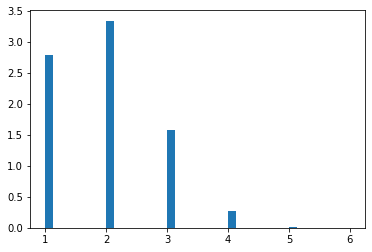

In [22]:
# initial values pretty much completely guessed, should be built off census data
lower, upper = 1, 8
mu, sigma = 2.2, 0.98

household_size_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
fig, ax = plt.subplots(1, 1)
ax.hist(household_size_dist.rvs(100_000).astype(int), density=True, bins=40)
plt.show()
del fig, ax

##### Workplace Size Distribution

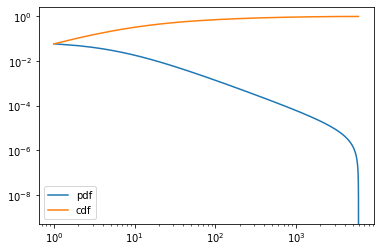

In [23]:
# inspired from https://www.nature.com/articles/nature04795 supplementary information
def workplace_size_truncated_power_law(m_max, a, c):
    m = np.arange(1, m_max + 1, dtype='float')
    pmf = (
            (
                    (
                            ((1 + (m_max / a))
                             /
                             (1 + (m / a)))
                            ** c)
                    - 1)
            /
            ((
                    ((1 + (m_max / a)) ** c)
                    - 1)))
    pmf /= pmf.sum()

    return stats.rv_discrete(values=(range(1, m_max + 1), pmf))

max_size = 5920
workplace_size_dist = workplace_size_truncated_power_law(m_max=max_size, a=5.36, c=1.34)

x = np.arange(1, max_size + 1)
fig, ax = plt.subplots()
y_pdf = workplace_size_dist.pmf(x)
y_cdf = workplace_size_dist.cdf(x)
ax.set_xscale(value="log")
ax.set_yscale(value="log")
ax.plot(x, y_pdf, label='pdf')
ax.plot(x, y_cdf, label='cdf')
ax.legend()
del x, fig, ax

In [30]:
class Person():
    def __init__(self, uid, household_uid, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.pos = pos
        self.age = None        

people = []

def add_new_person(household_uid, pos):
    
    new_person = Person(uid=len(people), household_uid=household_uid, pos=pos)
    people.append(new_person)
    
    return new_person

In [31]:
class Household():
    def __init__(self, uid, max_inhabitants, pos: Tuple[float, float]):
        self.uid = uid
        self.inhabitants = 0
        self.max_inhabitants = max_inhabitants
        self.pos = pos
    
    def to_dict(self):
        return {
            'uid': self.uid,
            'inhabitants': self.inhabitants,
            'max_inhabitants': self.max_inhabitants,
            'pos': self.pos,
        }
    
households = []

def add_new_household(pos_geometry):
    max_inhabitants = household_size_dist.rvs(1)[0]
    
    new_household = Household(uid=len(households), max_inhabitants=max_inhabitants, pos=pos_geometry)
    households.append(new_household)
    
    return new_household

In [32]:
class ResidenceType(IntEnum):
    HOUSE = 0
    SMALL_FLATS = 1  # Perhaps a few floors or flats in one building
    LARGE_FLATS = 2  # Generally high-rise, shared lifts, etc.


# Again basically random numbers, need to be brought in from Census
residence_params = {
    'max_household_capacity': 7,
    ResidenceType.HOUSE: {
        'max_households': 2
    },
    ResidenceType.SMALL_FLATS: {
        'max_households': 10
    },
    ResidenceType.LARGE_FLATS: {
        'max_households': 150
    }
}

residential_buildings['residence_type'] = ResidenceType.HOUSE
residential_buildings.loc[residential_buildings['building'].isin(['apartments', 'flats']), 'residence_type'] = ResidenceType.SMALL_FLATS
residential_buildings.drop('building', axis='columns', inplace=True)

NameError: name 'residential_buildings' is not defined

### Person Generation and Household Allocation

In [27]:
%%time
residences_to_households = defaultdict(lambda: [])
residential_buildings = residential_buildings.to_crs(OUT_CRS)

# reset lists
households = []
people = []
failures = 0

# for each tile of population
for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        index = (row, col)
        people_at_tile = wp_clipped[row, col]
        
        if np.isnan(people_at_tile):
            continue
        
        # residences near the center of the tile
        local_residences_indices = residences_in_radius.loc[np.ravel_multi_index(index, wp_clipped.shape), 'Elements in Radius']
        
        for _ in range(int(people_at_tile)):
            shuffled_indices = np.random.permutation(local_residences_indices)

            chosen_household = None

            for residence_index in shuffled_indices:
                households_at_residence = [households[household_uid] for household_uid in residences_to_households[residence_index]]
                possible_households = [household for household in households_at_residence if household.inhabitants < household.max_inhabitants]

                if len(possible_households) != 0:
                    chosen_household = random.choice(possible_households)
                    chosen_household.inhabitants += 1
                    break
                else:
                    building_type = residential_buildings.loc[residence_index, 'residence_type']
                    
                    if len(households_at_residence) < residence_params[building_type]['max_households']:
                        pos = residential_buildings.loc[residence_index].geometry.centroid
                        pos = (pos.x, pos.y)
                        chosen_household = add_new_household(pos)
                        residences_to_households[residence_index].append(chosen_household.uid)
                        
                        chosen_household.inhabitants += 1
                        
            else:  # failed to find an available household, or residence to make a new household in, so upgrade a residence 
                smaller_residences_indices = [residence_index for residence_index in local_residences_indices 
                                              if residential_buildings.loc[residence_index, 'residence_type'] != ResidenceType.LARGE_FLATS]
                
                if len(smaller_residences_indices) != 0:
                    chosen_residence_index = random.choice(smaller_residences_indices)
                    residential_buildings.loc[chosen_residence_index, 'residence_type'] = ResidenceType(residential_buildings.loc[chosen_residence_index, 'residence_type'] + 1)
                    
                    pos = residential_buildings.loc[chosen_residence_index].geometry.centroid
                    pos = (pos.x, pos.y)
                    chosen_household = add_new_household(pos)
                    residences_to_households[chosen_residence_index].append(chosen_household.uid)
                else:
                        failures += 1
                        continue
#                     raise Exception("Bugger gotta deal with this")
            add_new_person(chosen_household.uid, chosen_household.pos)    
print(f"Failures: {failures}/{int(wp_clipped.sum())}, Failure Rate: {failures/int(wp_clipped.sum()):.2f}")

Failures: 1013694/3231229, Failure Rate: 0.31
CPU times: user 50min, sys: 35.3 s, total: 50min 35s
Wall time: 50min 46s


In [28]:
Path(f'pickles/{DATASET_NAME}/people_list').write_bytes(pickle.dumps(people))
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'household_uid': person.household_uid} for person in people])
del people

In [29]:
# Note: RIDICULOUSLY HACKY, will be replaced with something far more rigorous, no numbers should be taken seriously in this
def gen_ages(group):
    max_num_adults = random.choices([2, 3, 4, 5], weights=[0.8, 0.1, 0.07, 0.03])[0]
    ages = []
    
    num_inhabitants = len(group)
    
    if num_inhabitants > 2:
        num_carers = random.choices([1, 2], weights=[0.2, 0.8])[0]
                
        if random.random() > 0.8: # elderly living with family
            for _ in range(num_carers):
                ages.append(random.randint(40, 50))
            # add some carers
            for _ in range(num_inhabitants - num_carers):
                ages.append(random.randint(70, 108))
        else:
            for _ in range(num_carers):
                ages.append(random.randint(20, 50))
            for _ in range(num_inhabitants - num_carers):
                ages.append(random.randint(0, 18))
    else: 
        ages = [random.randint(18, 108) for _ in range(num_inhabitants)]
    
    return ages

In [30]:
%%time
people_df['age'] = people_df.groupby('household_uid')['uid'].transform(gen_ages)

CPU times: user 2min 30s, sys: 12.2 s, total: 2min 42s
Wall time: 2min 42s


### Workplace Selection and Allocation

In [31]:
# generate workplace capacities
trimmed_work['capacity'] = workplace_size_dist.rvs(size=len(trimmed_work))
# reproject workplaces
trimmed_work = trimmed_work.to_crs(OUT_CRS)

In [32]:
Path(f'pickles/{DATASET_NAME}/households_list').write_bytes(pickle.dumps(households))
Path(f'pickles/{DATASET_NAME}/people_df').write_bytes(pickle.dumps(people_df))
Path(f'pickles/{DATASET_NAME}/workplaces_gdf').write_bytes(pickle.dumps(trimmed_work))
Path(f'pickles/{DATASET_NAME}/boundary').write_bytes(pickle.dumps(boundary))
Path(f'pickles/{DATASET_NAME}/transit_graph').write_bytes(pickle.dumps(graph))
Path(f'pickles/{DATASET_NAME}/edge_rides_df').write_bytes(pickle.dumps(edge_rides))

55679422

In [36]:
# import pickle
# from pathlib import Path
# households = pickle.loads(Path(f'pickles/{DATASET_NAME}/households_list').read_bytes())
# people_df = pickle.loads(Path(f'pickles/{DATASET_NAME}/people_df').read_bytes())
# trimmed_work = pickle.loads(Path(f'pickles/{DATASET_NAME}/workplaces_gdf').read_bytes())
# boundary = pickle.loads(Path(f'pickles/{DATASET_NAME}/boundary').read_bytes())
# graph = pickle.loads(Path(f'pickles/{DATASET_NAME}/transit_graph').read_bytes())
# edge_rides = pickle.loads(Path(f'pickles/{DATASET_NAME}/edge_rides_df').read_bytes())

In [12]:
bucket_size = 500 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 530, x: 437


In [13]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()
print(len(unemployed))

1186592


In [14]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size)).astype(int) - 1
unemployed['bucket_y'] = np.ceil(y_len - ((unemployed['y'] - boundary_miny) / bucket_size)).astype(int) - 1

In [15]:
def make_buckets():
    unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
    for person in unemployed.itertuples():
        unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)
    
    return unemployed_bucket

In [16]:
%%time
unemployed_bucket = make_buckets()

CPU times: user 1.66 s, sys: 15.6 ms, total: 1.67 s
Wall time: 1.69 s


In [17]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, centre_y=None, centre_x=None, radius=None):
    if centre_x is None: # use the middle of the image
        centre_x = int(w / 2)
    if centre_y is None:
        centre_y = int(h / 2)
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(centre_y, centre_x, (w - centre_x), (h - centre_y))

    y, x = np.ogrid[-centre_y:(h - centre_y), -centre_x:(w - centre_x)]
    mask = (x * x) + (y * y) <= (radius * radius)
    return mask

In [18]:
class NoViablePeopleError(Exception):
    pass

# A generator that takes a center point and a radius, and efficiently finds an unemployed person in that radius 
def valid_unemployed_within_dist(y, x, dist, cache_size=200):
    counts = np.array([list(map(len, row)) for row in unemployed_bucket])
    y = y_len - int(math.ceil((y - boundary_miny) / bucket_size)) - 1
    x = int(math.ceil((x - boundary_minx) / bucket_size)) - 1
    dist = dist / bucket_size
    mask = create_circular_mask(h=y_len, w=x_len, centre_y=y, centre_x=x, radius=dist)
    
    indices = np.argwhere(mask)
    if np.sum(counts[mask]) == 0:
        raise NoViablePeopleError(f'No viable unemployed people left around (x:{x}, y:{y})')
    probabilities = counts[mask] / np.sum(counts[mask])
    
    chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities) # a cache of sampled choices
    chosen_iter = iter(chosen_buckets)
    failures = 0
    
    while True:
        try:
            next_bucket_pos = tuple(indices[next(chosen_iter)])
        except StopIteration: # used up the cache, repopulate with some more random choices
            chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
            chosen_iter = iter(chosen_buckets)
            continue
        try: 
            next_person = unemployed_bucket[next_bucket_pos[0]][next_bucket_pos[1]].pop()
        except IndexError: # no unemployed people in that bucket
            failures += 1
            if failures > 300: # we had a lot of failures, recalc the probability map
                failures = 0
                
                counts = np.array([list(map(len, row)) for row in unemployed_bucket])
                
                total_unemployed_left = np.sum(counts[mask])
                if total_unemployed_left == 0:
                    raise NoViablePeopleError(f'No viable unemployed people left around ({x}, {y})')
                
                probabilities = counts[mask] / total_unemployed_left
                
                chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
                chosen_iter = iter(chosen_buckets)
            continue
            
        yield next_person

In [41]:
%%time
travel_times = dict(nx.all_pairs_dijkstra_path_length(graph, cutoff=90, weight='minutes'))  # {node(str): {target(str): dist(num)}}
Path(f'pickles/{DATASET_NAME}/travel_times').write_bytes(pickle.dumps(travel_times))

# travel_times = pickle.loads(Path(f'pickles/{DATASET_NAME}/travel_times').read_bytes())

CPU times: user 7min 46s, sys: 6.19 s, total: 7min 52s
Wall time: 7min 54s


1062719881

In [19]:
graph_node_ids = osmnx.utils_graph.graph_to_gdfs(graph, edges=False).osmid # the graph module removes some nodes (probably unconnected ones, TODO investigate)
nodes = osmnx.utils_graph.graph_to_gdfs(graph, edges=False).set_crs(epsg=4326)
transit_node_positions = np.array(list(nodes.loc[graph_node_ids].to_crs(OUT_CRS).geometry.centroid.apply(lambda x: (x.x, x.y))))
nodes_to_radius_search = dict(zip(list(graph_node_ids), list(map(lambda pos: valid_unemployed_within_dist(pos[1], pos[0], 5_000, 100), transit_node_positions))))
nodeKdTree = cKDTree(data=transit_node_positions)
del nodes, transit_node_positions

In [20]:
MIN_TRAVEL_TIME = 15
graph_node_ids_to_index = {node_id: index for index, node_id in enumerate(list(graph_node_ids))}

transit_nodes_to_commuting_nodes = {graph_node_ids_to_index[src_node_id]: [target_node_id for target_node_id, time in times_dict.items() if time > MIN_TRAVEL_TIME] 
                   for src_node_id, times_dict in travel_times.items()}

def get_transit_nodes_to_commuting_nodes():
    return deepcopy(transit_nodes_to_commuting_nodes)
    
del travel_times, graph_node_ids_to_index

In [21]:
class NoNearbyTransitNodesError(Exception):
    pass

def get_nearby_transit_nodes(workplace):
    dist = 1_000
    nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    while len(nearby_transit_nodes) == 0 and dist <= 5_000:
        dist += 1000
        nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    if len(nearby_transit_nodes) == 0:
        raise NoNearbyTransitNodesError(f"No transit nodes were found within walking distance of workplace {workplace.index}")
    
    return nearby_transit_nodes

In [22]:
from enum import Enum
class TransportType(Enum):
    PUBLIC_TRANSIT = 0,
    DRIVING = 1,
    CYCLING = 2,
    WALKING = 3

In [23]:
%%time
to_allocate = len(unemployed)
print(f'Trying to allocate {to_allocate} people, {len(trimmed_work)} workplaces')

unemployed_bucket = make_buckets()
reachable_nodes = get_transit_nodes_to_commuting_nodes()

people_to_workplaces = [None] * len(people_df)
people_to_transport_type = [None] * len(people_df)

failures_per_transport = {transport_type: 0 for transport_type in TransportType}
complete_failures = 0
successes = 0
workplace_indices = []

for index, workplace in enumerate(trimmed_work.sample(frac=1).itertuples()): # iterate over shuffled workplaces
    if successes >= to_allocate:
        print(f'Allocated all people after {index} workplaces')
        break
    if index < 9:
        workplace_indices.append(workplace.index) # hacky way to select some workplaces for analysis later on
        
    transport_options = [TransportType.PUBLIC_TRANSIT, TransportType.DRIVING, TransportType.CYCLING, TransportType.WALKING]
    
    try:
        nearby_transit_nodes = get_nearby_transit_nodes(workplace)
    except NoNearbyTransitNodesError:
        transport_options.remove(TransportType.PUBLIC_TRANSIT)
        
    valid_unemployed_gen_60k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 60_000)
    valid_unemployed_gen_20k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 20_000)
    valid_unemployed_gen_5k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 5_000)
    
    for _ in range(workplace.capacity):
        # TODO update to better reflect real distributions if possible, maybe weight it by workplace size, more likely to walk if you own the business
        random.shuffle(transport_options)
        random_transport = iter(transport_options)
        
        person_id = None
        transport_type = None
        
        while (person_id == None):
            try:
                transport_type = next(random_transport)
            except StopIteration:
                break
            if transport_type == TransportType.PUBLIC_TRANSIT:
                source_node_index = np.random.choice(nearby_transit_nodes)
                try:
                    while (person_id == None):
                        dest_osmid = random.choice(reachable_nodes[source_node_index])
                        try:
                            person_id = next(nodes_to_radius_search[dest_osmid])
                        except StopIteration:
                            reachable_nodes[source_node_index].remove(dest_osmid)
                except (NoViablePeopleError, IndexError):
                    transport_options.remove(transport_type)
                    failures_per_transport[transport_type] += 1
            elif transport_type == TransportType.DRIVING:
                try:
                    person_id = next(valid_unemployed_gen_60k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
                    failures_per_transport[transport_type] += 1
            elif transport_type == TransportType.CYCLING:
                try:
                    person_id = next(valid_unemployed_gen_20k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
                    failures_per_transport[transport_type] += 1
            elif transport_type == TransportType.WALKING:
                try:
                    person_id = next(valid_unemployed_gen_5k)
                except NoViablePeopleError:
                    failures_per_transport[transport_type] += 1
                    transport_options.remove(transport_type)
        
        if person_id:
            if transport_type:
                people_to_transport_type[person_id] = transport_type
            
            people_to_workplaces[person_id] = workplace.index
            successes += 1
            if successes >= to_allocate:
                break
        else:
            complete_failures +=1
            break            
    
print(f'Successes: {successes}, Failures: {complete_failures}')

Trying to allocate 1186592 people, 46085 workplaces
Successes: 1186591, Failures: 40398
CPU times: user 43min 56s, sys: 1min 27s, total: 45min 24s
Wall time: 45min 40s


In [26]:
Path(f'pickles/{DATASET_NAME}/people_to_workplaces_list').write_bytes(pickle.dumps(people_to_workplaces))
Path(f'pickles/{DATASET_NAME}/people_to_transport_list').write_bytes(pickle.dumps(people_to_transport_type))

3290537

In [24]:
failures_per_transport

{<TransportType.PUBLIC_TRANSIT: (0,)>: 22254,
 <TransportType.DRIVING: (1,)>: 19484,
 <TransportType.CYCLING: (2,)>: 20637,
 <TransportType.WALKING: 3>: 21250}

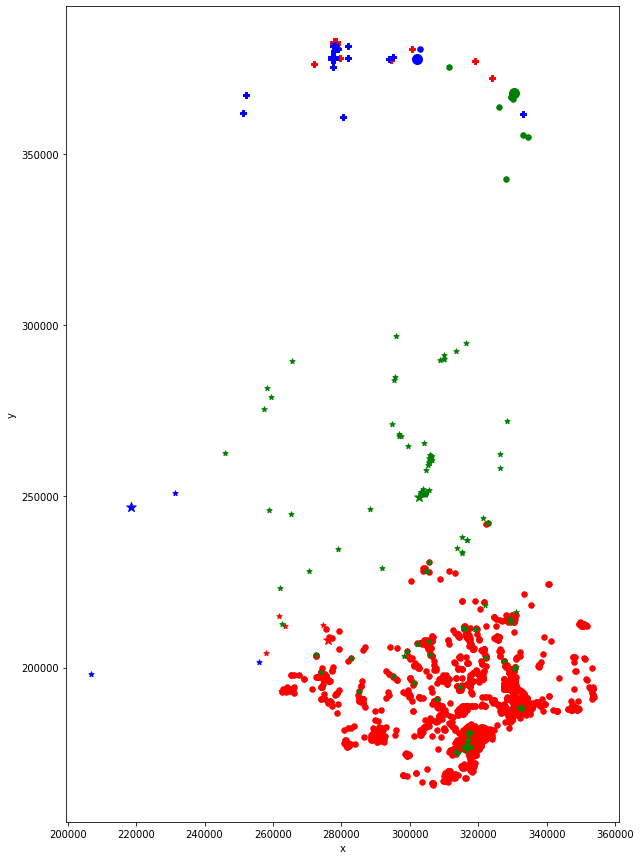

In [25]:
workplaces_to_people = defaultdict(list)
for person_id, workplace_index in enumerate(people_to_workplaces):
    if workplace_index is not None:
        workplaces_to_people[workplace_index].append(person_id)

example_workplaces_to_people = {ind: workplaces_to_people[ind] for ind in workplace_indices}
        
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
marker_styles = [
                ('red', 'o'), ('blue', 'o'), ('green', 'o'),
                ('red', 'P'), ('blue', 'P'), ('green', 'P'),
                ('red', '*'), ('blue', '*'), ('green', '*')
                ]

for (workplace_index, worker_indices), (color, marker) in zip(example_workplaces_to_people.items(), marker_styles):
    trimmed_work.iloc[[workplace_index]].plot(ax=ax, markersize=100, c=color, marker=marker)
    workers = people_df.iloc[worker_indices]
    workers.plot(ax=ax, x='x', y='y', kind='scatter', s=30, c=color, marker=marker)
del fig, ax

## Transform and Write Model to FlatBuffer

##### Translate co-ordinates to have the minima start at 0

In [27]:
def normalise_x_y(x, y):
    norm_x = (x - boundary_minx)
    norm_y = (y - boundary_miny)
    return (norm_x, norm_y)

In [37]:
nodes, edges = osmnx.utils_graph.graph_to_gdfs(graph) # get the nodes and edges dataframes

# We need a lookup of an OSM_ID to the node's index as we're using the index as the ID in the Flatbuffer
node_osmids_to_index = {osmid: index for index, osmid in enumerate(nodes.index)}

nodes = nodes.set_crs(epsg=4326).to_crs(OUT_CRS).reset_index(drop=True)
nodes_norm_x, nodes_norm_y = normalise_x_y(x=nodes.geometry.centroid.x, y=nodes.geometry.centroid.y)
nodes['pos'] = list(zip(nodes_norm_x, nodes_norm_y))

edges = edges.set_crs(epsg=4326).to_crs(OUT_CRS).reset_index()
edges_norm_x, edges_norm_y = normalise_x_y(x=edges.geometry.centroid.x, y=edges.geometry.centroid.y)
edges['u'] = edges['u'].apply(lambda osm_id: node_osmids_to_index[osm_id])
edges['v'] = edges['v'].apply(lambda osm_id: node_osmids_to_index[osm_id])

edge_rides['u'] = edge_rides['u'].apply(lambda osm_id: node_osmids_to_index[osm_id])
edge_rides['v'] = edge_rides['v'].apply(lambda osm_id: node_osmids_to_index[osm_id])

In [38]:
allocated_workplaces = list(workplaces_to_people.keys())
workplaces = trimmed_work.iloc[allocated_workplaces].copy()

# We need a lookup of a workplace index within the full dataframe to its index out of allocated workplaces
workplaces_old_index_to_new = {old_index: index for index, old_index in enumerate(workplaces.index)}
workplaces_old_index_to_new[2 ** 32 - 1] = 2 ** 32 - 1 # set the uint32 MAX to stay the same

workplaces = workplaces.to_crs(OUT_CRS).reset_index(drop=True)

workplaces_norm_x, workplaces_norm_y = normalise_x_y(x=workplaces.geometry.centroid.x, y=workplaces.geometry.centroid.y)
workplaces['pos'] = list(zip(workplaces_norm_x, workplaces_norm_y))

In [39]:
people_to_workplace_ids = [2 ** 32 - 1] * len(people_df)  # Initial value of uint32 MAX
for old_workplace_id, employee_ids in workplaces_to_people.items():
    for employee_id in employee_ids:
        people_to_workplace_ids[employee_id] = workplaces_old_index_to_new[old_workplace_id]

people_df['workplace_uid'] = people_to_workplace_ids

In [40]:
households_norm_pos = [normalise_x_y(household.pos[0], household.pos[1]) for household in households]

In [41]:
# recalculate bounds with padding from all input data to account for discrepancies in co-ordinate transforms
position_lists = [workplaces['pos'], nodes['pos'], households_norm_pos]
max_x = 0
max_y = 0
for pos_list in position_lists:
    max_x = max(max_x, max(list(pos_list), key=itemgetter(0))[0])
    max_y = max(max_y, max(list(pos_list), key=itemgetter(1))[0])

In [42]:
# TODO, nonsense atm
# All in bytes
AGENT_SIZE = 32
WORKPLACE_SIZE = 8
HOUSEHOLD_SIZE = 8
CONTAINER_SIZE = 8
TRANSIT_NODE_SIZE = 8
TRANSIT_EDGE_SIZE = 16

initial_buffer_size = (len(people_df) * AGENT_SIZE
                       + len(households) * HOUSEHOLD_SIZE
                       + len(workplaces_to_people) * WORKPLACE_SIZE
                       + len(nodes) * TRANSIT_NODE_SIZE
                       + len(edges) * TRANSIT_EDGE_SIZE
                      )
print(initial_buffer_size)

76923792


In [43]:
import generated.OutbreakSim.Model.Vec2 as gen_vec2
import generated.OutbreakSim.Model.Bounds as gen_bounds
import generated.OutbreakSim.Model.Model as gen_model
import generated.OutbreakSim.Model.Agents as gen_agents
import generated.OutbreakSim.Model.Households as gen_households
import generated.OutbreakSim.Model.Workplaces as gen_workplaces
import generated.OutbreakSim.Model.TransitRide as gen_transit_ride
import generated.OutbreakSim.Model.TransitNode as gen_transit_node
import generated.OutbreakSim.Model.TransitEdge as gen_transit_edge
import generated.OutbreakSim.Model.TransitEdgeRides as gen_transit_edge_rides
import generated.OutbreakSim.Model.TransitGraph as gen_transit_graph

In [44]:
builder = flatbuffers.Builder(initial_buffer_size)

In [45]:
%%time
# Create `vectors` representing the attributes of the Agents SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.

num_people = len(people_df)
gen_agents.AgentsStartAgeVector(builder, num_people)
for age in people_df['age'][::-1]:
    builder.PrependUint8(int(age))
agents_age_vec = builder.EndVector(num_people)

gen_agents.AgentsStartHouseholdIndexVector(builder, num_people)
for household_uid in people_df['household_uid'][::-1]:
    builder.PrependUint32(int(household_uid))
agents_household_index_vec = builder.EndVector(num_people)

gen_agents.AgentsStartWorkplaceIndexVector(builder, num_people)
for workplace_uid in people_df['workplace_uid'][::-1]:
    builder.PrependUint32(int(workplace_uid))
agents_workplace_index_vec = builder.EndVector(num_people)

del num_people

gen_agents.AgentsStart(builder)
gen_agents.AgentsAddAge(builder, agents_age_vec)
gen_agents.AgentsAddHouseholdIndex(builder, agents_household_index_vec)
gen_agents.AgentsAddWorkplaceIndex(builder, agents_workplace_index_vec)
built_agents = gen_agents.AgentsEnd(builder)

CPU times: user 14.4 s, sys: 15.6 ms, total: 14.4 s
Wall time: 14.4 s


In [46]:
%%time
# Create `vectors` representing the attributes of the Households SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
num_households = len(households)
gen_households.HouseholdsStartPosVector(builder, num_households)
for household_pos in reversed(households_norm_pos):
    gen_vec2.CreateVec2(builder, household_pos[0], household_pos[1])
households_pos_vec = builder.EndVector(num_households)

gen_households.HouseholdsStart(builder)
gen_households.HouseholdsAddPos(builder, households_pos_vec)
built_households = gen_households.HouseholdsEnd(builder)

CPU times: user 6.48 s, sys: 0 ns, total: 6.48 s
Wall time: 6.48 s


In [47]:
%%time
# Create `vectors` representing the attributes of the Workplaces SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
num_workplaces = len(workplaces)
gen_workplaces.WorkplacesStartPosVector(builder, num_workplaces)
for pos in workplaces['pos'][::-1]:
    gen_vec2.CreateVec2(builder, pos[0], pos[1])
workplaces_pos_vec = builder.EndVector(num_workplaces)

del num_workplaces

gen_workplaces.WorkplacesStart(builder)
gen_workplaces.WorkplacesAddPos(builder, workplaces_pos_vec)
built_workplaces = gen_workplaces.WorkplacesEnd(builder)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 43.2 ms


In [49]:
# Create Model
gen_model.ModelStart(builder)
built_bounds = gen_bounds.CreateBounds(builder, 0, 0, boundary_maxx - boundary_minx, boundary_maxy - boundary_miny)
gen_model.ModelAddBounds(builder, built_bounds)
gen_model.ModelAddAgents(builder, built_agents)
gen_model.ModelAddHouseholds(builder, built_households)
gen_model.ModelAddWorkplaces(builder, built_workplaces)
gen_model.ModelAddTransitGraph(builder, built_transit_graph)
built_model = gen_model.ModelEnd(builder)
builder.Finish(built_model)
buf = builder.Output()

In [50]:
out_path = Path(f"./output/{DATASET_NAME}.txt")
out_path.write_bytes(buf)

48519344